In [12]:
from dataset import CoordinateDataset

DATASET = 'data/1000.csv'
coordinate_dataset = CoordinateDataset(DATASET)
coordinates = [d[1] for d in coordinate_dataset]

In [13]:
import torch
from model import Transformer

MODEL_PATH = 'models/model.pickle'
# TODO: Load the parameters too
# TODO: Why 987 and not 1000?
model = Transformer(d_model=32, nhead=2, d_hid=128, nlayers=1, dropout=0.0, ntoken=987)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# Embeddings are linear maps of coordinates
A transformer that is trained on city-token to distance learns as its embeddings a linear map of the true coordinates of the cities.

Mean squared error: 63.50594120224277
Example predictions:
Prediction 1: [[ 23.736982 104.20327 ]], Actual: (21.0283, 105.8542)
Prediction 2: [[ 22.205433 -78.49221 ]], Actual: (21.1606, -86.8475)
Prediction 3: [[25.5456   50.291317]], Actual: (26.225, 50.5775)
Prediction 4: [[-26.42684   36.529743]], Actual: (-26.6736, 27.9319)
Prediction 5: [[9.507408  4.0705605]], Actual: (6.3333, 5.6222)


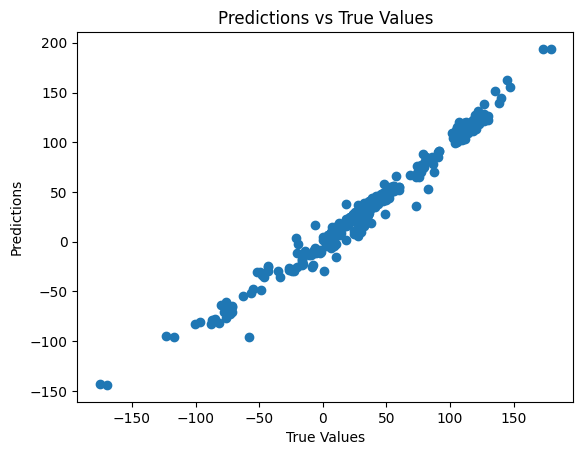

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

embeddings = None
for param in model.embedding.parameters():
    embeddings = param.detach().numpy()
    break

X_train, X_test, y_train, y_test = train_test_split(embeddings, coordinates, test_size=0.2, random_state=42)
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)
print("Mean squared error:", np.mean((y_pred - y_test) ** 2))

print("Example predictions:")
for i in range(5):
    prediction = linear_regressor.predict([X_test[i]])
    print(f"Prediction {i+1}: {prediction}, Actual: {y_test[i]}")

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()


In [19]:
import math

from torch.utils.data import DataLoader

from dataset import CityDistanceDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

city_distance_dataset = CityDistanceDataset(DATASET)
coordinate_dataset = CoordinateDataset(DATASET, normalise=False)

city_latitudes = [coordinate_dataset[city][1][0] for city in range(len(coordinate_dataset))]
sine_latitudes = []
for i in range(len(city_distance_dataset)):
    city = city_distance_dataset[i][0][0]
    latitude = city_latitudes[city]
    sine_latitude = math.sin(math.radians(latitude))
    sine_latitudes.append(sine_latitude)

def get_activation(layer):
    def hook(module, input, output):
        module.activation = output.detach()
    return hook

hook = model.transformer.transformer_encoder.register_forward_hook(get_activation('encoder'))

dataloader = DataLoader(city_distance_dataset, batch_size=4096, shuffle=False)
activations = []
model = model.to(device)
for i, (x, y) in enumerate(dataloader):
    x = torch.stack([x[0], x[1]], dim=1).to(device)
    model(x)
    activations.append(model.transformer.transformer_encoder.activation)
activations = torch.cat(activations)
activations = activations.reshape(len(activations), -1)

X_train, X_test, y_train, y_test = train_test_split(activations.detach().cpu().numpy(), sine_latitudes, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean squared error:", np.mean((y_pred - y_test) ** 2))

print("Example predictions:")
for i in range(5):
    prediction = model.predict([X_test[i]])
    print(f"Prediction {i+1}: {prediction}, Actual: {y_test[i]}")

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()